In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch

In [2]:
train_data = datasets.FashionMNIST(root='./data',
                                   download=True,
                                   train=True,
                                   transform=ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 14847515.71it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 274133.57it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4916108.10it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22032935.71it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
train_data.data.size()

torch.Size([60000, 28, 28])

In [4]:
torch.unique(train_data.targets) #we have 10 classes

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
test_data = datasets.FashionMNIST(root='./data', download=True, train=False, transform=ToTensor())

In [6]:
test_data.data.size()

torch.Size([10000, 28, 28])

In [7]:
BATCH_SIZE = 64

loader = {
    'train': torch.utils.data.DataLoader(dataset=train_data,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         num_workers=2),

    'test': torch.utils.data.DataLoader(dataset=test_data,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=2)
}

In [37]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=2)
    self.fc1 = nn.Linear(in_features=2*2*64, out_features=288)
    self.fc2 = nn.Linear(in_features=288, out_features=10)
    self.dropout = nn.Dropout(0.3)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2) # output shape torch.Size([200, 32, 7, 7])
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 2*2*64)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)

    return F.softmax(x)

In [62]:
len(loader['train'].dataset)

60000

In [61]:
len(loader['train'])*BATCH_SIZE

60032

In [11]:
for inputs, targets in loader['train']:
  print(targets.data)
  break

tensor([5, 3, 7, 5, 7, 3, 4, 2, 2, 8, 4, 8, 0, 7, 5, 4, 1, 4, 6, 9, 5, 0, 7, 7,
        6, 5, 7, 7, 8, 7, 5, 2, 0, 2, 0, 8, 2, 8, 9, 2, 3, 6, 1, 9, 5, 7, 2, 2,
        5, 0, 3, 0, 7, 0, 9, 1, 9, 8, 5, 9, 3, 8, 2, 3])


In [12]:
for inputs, targets in loader['train']:
  print(targets)
  break

tensor([0, 0, 5, 1, 8, 5, 0, 4, 5, 3, 0, 3, 2, 0, 1, 1, 2, 0, 2, 3, 6, 2, 9, 5,
        1, 7, 7, 7, 2, 6, 2, 0, 9, 5, 5, 9, 2, 1, 0, 1, 4, 8, 6, 2, 6, 3, 6, 4,
        1, 4, 6, 7, 5, 7, 2, 5, 6, 1, 7, 2, 0, 0, 8, 6])


In [74]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()

  train_loss = 0 # train loss per epoch
  corrects = 0

  for batch_id, (inputs, targets) in enumerate(loader['train']):
    inputs, targets = inputs.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()

    pred = outputs.argmax(dim=1, keepdim=False)
    corrects += torch.sum(pred == targets.data)
    train_loss += loss.item()
  print(f'\nTrain Epoch: {epoch} Avr loss: [{train_loss / len(loader["train"].dataset)}]\tAccuracy: [{corrects / len(loader["train"].dataset):.0%}]')
  return train_loss/6, corrects/6


def test():
  model.eval()

  test_loss = 0
  corrects = 0

  with torch.no_grad():
    for val_inputs, val_targets in loader['test']:
      val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)

      val_outputs = model(val_inputs)
      loss = loss_fn(val_outputs, val_targets)
      val_pred = val_outputs.argmax(dim=1)
      test_loss += loss.item()
      corrects += torch.sum(val_pred == val_targets.data)
      # should print once at the end of each epoch
    print(f'Test set: Average val_loss: {test_loss / len(loader["test"].dataset)}, Val_Accuracy [{corrects}/{len(loader["test"].dataset)} ({corrects / len(loader["test"].dataset):.0%})]')
  return test_loss, corrects




Device: cuda


In [54]:
EPOCHS = 10

train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(1, EPOCHS+1):
  loss, acc = train(epoch)
  train_loss_history.append(loss)
  train_acc_history.append(acc.cpu().numpy())

  val_loss, val_acc = test()
  val_loss_history.append(val_loss)
  val_acc_history.append(val_acc.cpu().numpy())



<ipython-input-37-c3556bd8f073>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)



Train Epoch: 1 Avr loss: [0.02767182751695315]	Accuracy: [70%]
Test set: Average val_loss: 0.026552149057388306, Val_Accuracy [7717/10000 (77%)]

Train Epoch: 2 Avr loss: [0.0261308501124382]	Accuracy: [79%]
Test set: Average val_loss: 0.025939006459712984, Val_Accuracy [8108/10000 (81%)]

Train Epoch: 3 Avr loss: [0.025774206990003587]	Accuracy: [81%]
Test set: Average val_loss: 0.025984409379959106, Val_Accuracy [8053/10000 (81%)]

Train Epoch: 4 Avr loss: [0.025506127301851908]	Accuracy: [83%]
Test set: Average val_loss: 0.025527091240882874, Val_Accuracy [8359/10000 (84%)]

Train Epoch: 5 Avr loss: [0.025329876510302225]	Accuracy: [84%]
Test set: Average val_loss: 0.025381712925434112, Val_Accuracy [8447/10000 (84%)]

Train Epoch: 6 Avr loss: [0.025200414399305978]	Accuracy: [85%]
Test set: Average val_loss: 0.025528124403953554, Val_Accuracy [8357/10000 (84%)]

Train Epoch: 7 Avr loss: [0.025104688986142477]	Accuracy: [86%]
Test set: Average val_loss: 0.025268790912628174, Val_Ac

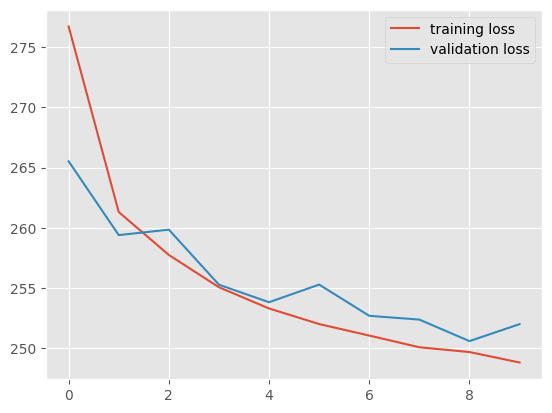

In [55]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(train_loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.legend()
plt.show()

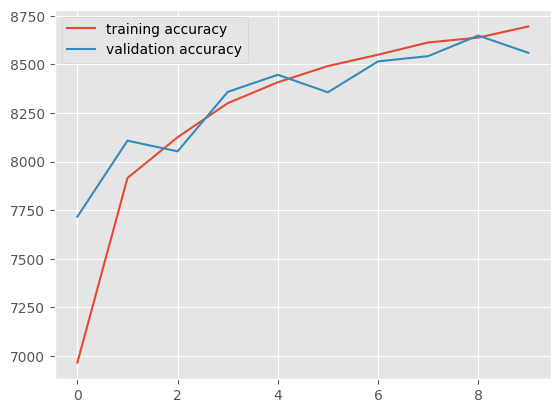

In [56]:
plt.style.use('ggplot')
plt.plot(train_acc_history, label='training accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.legend()
plt.show()

In [72]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

def plotImg():
  figure = plt.figure(figsize = (10, 10))
  cols, rows = 3, 3
  model.to('cpu')

  for i in range(1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, true_label = train_data[sample_idx]
    with torch.no_grad():
      pred = model(image)
      pred_label = pred.argmax(dim=1).item()
      predicted, actual = labels_map[pred_label], labels_map[true_label]
    figure.add_subplot(rows, cols, i)
    plt.title(predicted)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
  plt.show()

<ipython-input-37-c3556bd8f073>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


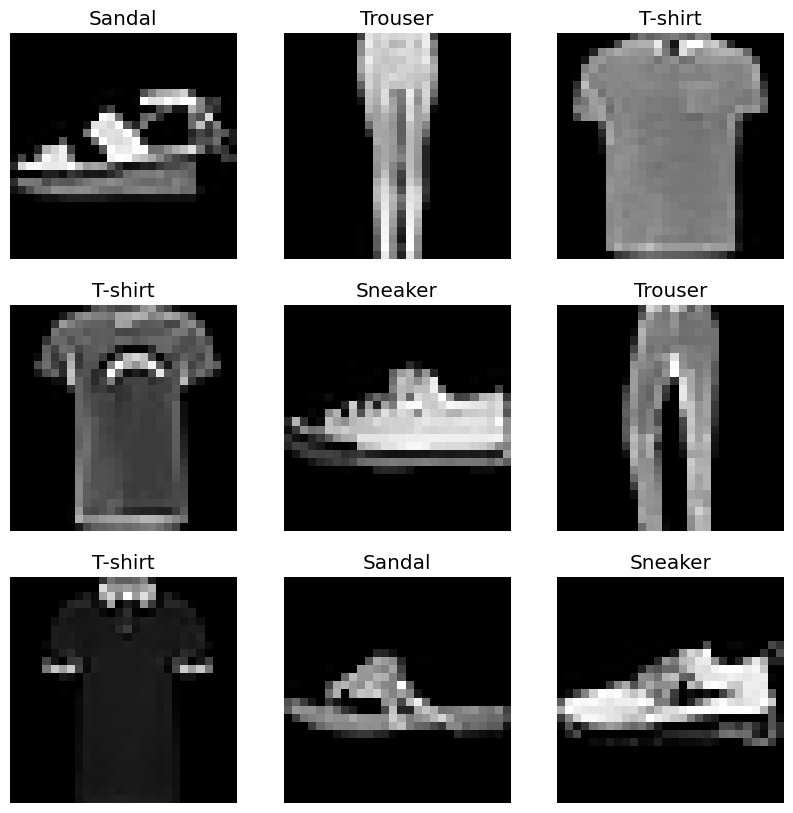

In [73]:
plotImg()